# Model of recall and cost

**Problem:** find the top-$K$ from $N$ elements (optionally in a batch of $B$ independent tasks).

**Approximate method:**
 1. Split $N$ elements into $L$ buckets (assume $L$ divides $N$), and compute the top-$J$ for each bucket (of size $N/L$).
 2. If $L\, J > K$, get the top-$K$ of these candidates.

**Metric:** _Recall_, if $S^*$ is a set of the true top-$K$ and $S$ is the set returned from our algorithm, recall $R = |S^* \cap S|/|S^*|$.

**Cost models:** (see explanation below)

 | Model | Algorithm | Cost |
 | --- | --- | --- |
 | Basic | - | $B\,N(\log_2 K + 1)$ |
 | Serial | Insertion sort | $B\,N(4\,K-2)$ |
 | Serial | Radix select & filter | $B\,N(4 \log_2 N + 4)$ |
 | Parallel | Scan-max | $K (2\log_2 N + 2)$ |
 | Parallel | Radix select & filter | $\log_2 N (2\log_2 N + 16)$ |

Therefore the cost of exact top-$K$ $C^{\mathrm{s}}(B, N, K)$ and $C^{\mathrm{p}}(B, N, K)$ under each model is:

$C^{\mathrm{b}} = B\,N(\log_2 K + 1)$

$C^{\mathrm{s}} = B\,N\min(4\,K-2 ,\, 4 \log_2 N + 4)$

$C^{\mathrm{p}} = \min(K (2\log_2 N + 2) ,\, \log_2 N (2\log_2 N + 16))$

And for approximate:

$C^{\mathrm{b}} = B\,N\,\log_2 J + \delta(L\,J>K) B\,L\,J\,\log_2 K$

$C^{\mathrm{s}} = B\,N\min(4\,J-2 ,\, 4 \log_2 L + 4) + \delta(L\,J>K) B\,L\,J\min(4\,K-2 ,\, 4 \log_2 (L\,J) + 4)$

$C^{\mathrm{p}} = \min(J (2\log_2 L + 2) ,\, \log_2 L (2\log_2 L + 16)) + \delta(L\,J>K) \min(K (2\log_2 (L\,J) + 2) ,\, \log_2 (L\,J) (2\log_2 (L\,J) + 16))$


---

## Explaining the cost model

**Model:**

 - Iterating through the input data linearly is free.
 - If statements are free, but all branches are "taken".
 - Fixed-offset addressing is free.
 - Ops that count (1): `{==, <, >, &, |, not, =}`
 - Ops that count (2): `{+=, &=, |=, ^=}`

For "basic", use computational complexity, for "serial", count total operations, for "parallel", count the shortest-path cost, assuming infinite parallel processors.

**Insertion sort (serial)**

```python
for i, x in data:
    if x > topk[0]:                 # +1
        topk[0] = (x, i)            # +1
    if topk[0] > topk[1]:           # +1
        swap(topk[0], topk[1])      # +3
    ...
    if topk[k-2] > topk[k-1]:       # +1
        swap(topk[k-2], topk[k-1])  # +3
```

**Scan-max (parallel)**

```python
for i in range(k):
    j = scan_argmax(data)        # +2*log2(N)
    topk[i] = (data[j], j)       # +1
    data[j] = -inf               # +1
```

**Radix select (serial)**

```python
# Radix select (base 2)
partition = 0
partition_mask = 0
count_left = 0
for r in range(log(N)-1, -1, -1):  # log(N) bits required to find partition
    count_1 = 0
    mask = 1 << r                            # +1
    partition |= mask                        # +2
    partition_mask |= mask                   # +2
    for i, x in data:
        if x & partition_mask == partition:  # +2
            count_1 += 1                     # +2
    
    count_0 = N - count_1                    # +1
    if K < count_left + count_0:             # +2
        partition ^= mask                    # +2
    else:
        count_left += count_0                # +2

# - scan (second scan may be needed for ties)
ptr = 0
for i, x in data:
    if x > partition:      # +1
        out[ptr] = (x, i)  # +1
        ptr += 1           # +2
```

**Radix select (parallel)**

```python
# (See serial version above)
# log(N)*
#  +2 test partition & bit
#  +2*log(N) sum
#  +12 update partition
# 2*log(N) cumsum
```

---

## Tests (WIP)

In [66]:
from collections import Counter
from math import log2
import random
import scipy.stats
import pandas as pd
from typing import Any, Iterable
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from functools import lru_cache
import numpy as np
matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})


@lru_cache(maxsize=2**24)
def binom_cdf(k: int, n: int, p: float) -> float:
    return scipy.stats.binom.cdf(k, n, p)


def recall_model(K: int, L: int, J: int) -> float:
    return (J + sum([binom_cdf(J-1, i, p=1/L) for i in range(J, K)])) / K


def recall_simulation(K: int, L: int, J: int, reps: int) -> float:
    recalls = []
    for _ in range(reps):
        counts = Counter(random.randint(0, L-1) for _ in range(K))
        recalls.append(sum(min(v, J) for v in counts.values()) / K)
    return sum(recalls) / len(recalls)

class costs:
    @classmethod
    def approx_topk(cls, K: int, N: int, B: int, L: int, J: int) -> int:
        return cls.topk(K=J, N=(N//L), B=B*L) + (J*L>K) * cls.topk(K=K, N=J*L, B=B)


class costs_basic(costs):
    @staticmethod
    def topk(K: int, N: int, B: int) -> int:
        return B * N * (log2(K) + 1)


class costs_serial(costs):
    @staticmethod
    def insertion(K: int, N: int, B: int) -> int:
        return B * N * (4*K - 2)

    @staticmethod
    def radix(K: int, N: int, B: int) -> int:
        return B * N * (4*log2(N) + 4)

    @classmethod
    def topk(cls, K: int, N: int, B: int) -> int:
        return min(cls.insertion(K=K, N=N, B=B), cls.radix(K=K, N=N, B=B))


class costs_parallel(costs):
    @staticmethod
    def scan(K: int, N: int, B: int) -> int:
        return K * (2*log2(N) + 2)

    @staticmethod
    def radix(K: int, N: int, B: int) -> int:
        return log2(N) * (2*log2(N) + 16)

    @classmethod
    def topk(cls, K: int, N: int, B: int) -> int:
        return min(cls.scan(K=K, N=N, B=B), cls.radix(K=K, N=N, B=B))

In [14]:
def _analyse(N: int, K: int, B: int) -> Iterable[dict[str, Any]]:
    yield dict(
        algorithm="exact",
        recall=1.0,
        cost_b=costs_basic.topk(K=K, N=N, B=B),
        cost_s=costs_serial.topk(K=K, N=N, B=B),
        cost_p=costs_parallel.topk(K=K, N=N, B=B),
    )
    for L in [2**i for i in range(1, int(log2(N)) + 1)]:
        for J in [2**i for i in range(0, int(log2(K)) + 1)]:
            if L * J >= K and (J < N//L):
                yield dict(
                    algorithm="approx",
                    L=L,
                    J=J,
                    recall=recall_model(K=K, L=L, J=J),
                    cost_b=costs_basic.approx_topk(K=K, N=N, B=B, L=L, J=J),
                    cost_s=costs_serial.approx_topk(K=K, N=N, B=B, L=L, J=J),
                    cost_p=costs_parallel.approx_topk(K=K, N=N, B=B, L=L, J=J),
                )

df = pd.DataFrame.from_records(
    dict(N=N, K=K, B=B, **m)
    for N in [2**i for i in range(10, 20)][:6]
    for K in [2**i for i in range(0, int(log2(N)))]
    for B in [1]
    for m in _analyse(N=N, K=K, B=B)
)
print(len(df))
df.head()

2565


,N,K,B,algorithm,recall,cost_b,cost_s,cost_p,L,J
0,1024,1,1,exact,1.0,1024.0,2048.0,22.0,NaN,NaN
1,1024,1,1,approx,1.0,1026.0,2052.0,24.0,2.0,1.0
2,1024,1,1,approx,1.0,1028.0,2056.0,24.0,4.0,1.0
3,1024,1,1,approx,1.0,1032.0,2064.0,24.0,8.0,1.0
4,1024,1,1,approx,1.0,1040.0,2080.0,24.0,16.0,1.0


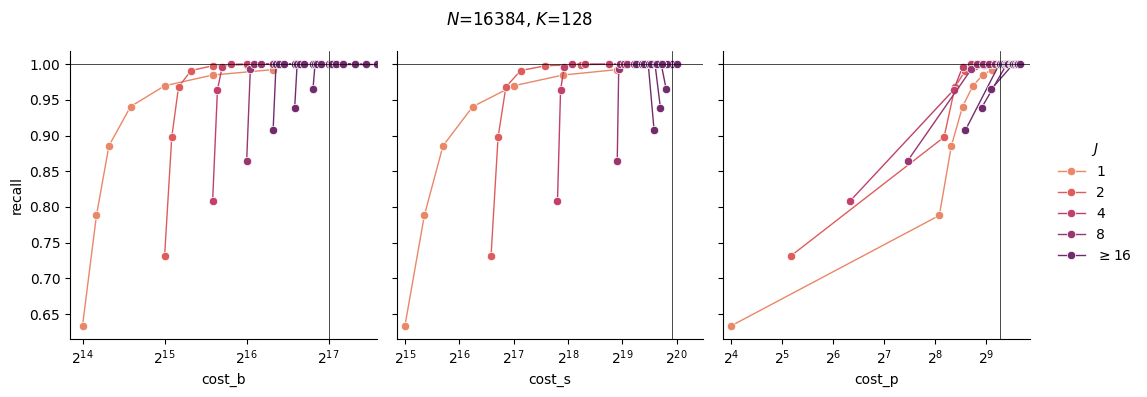

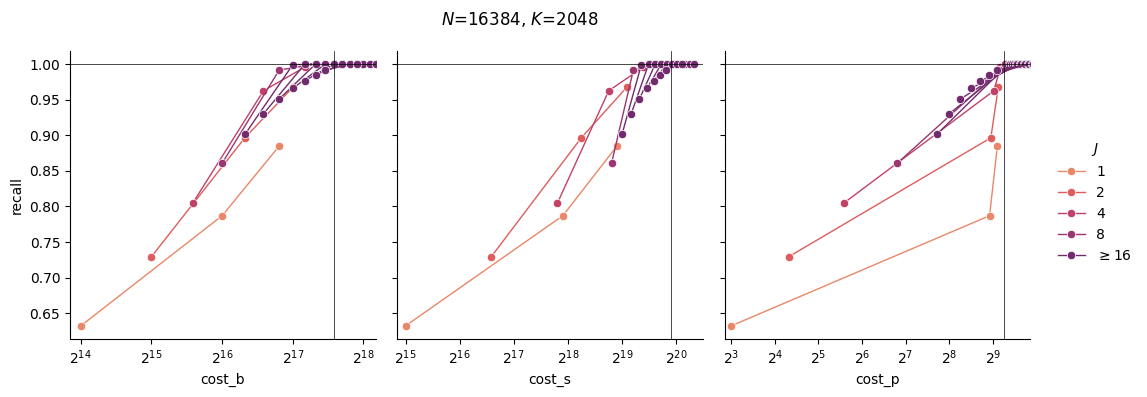

In [95]:
N, K = 16384, 128
for N, K in [(16384, 128), (16384, 2048)]:
    d = df[(df.N==N) & (df.K==K)]
    palette = sns.color_palette("flare", n_colors=5)
    logJ_to_hue = {logJ: palette[min(logJ, len(palette) - 1)]
                   for logJ in sorted(map(int, np.log2(d["J"].dropna().unique())))}

    fig, axs = plt.subplots(ncols=3, figsize=(3*3.5, 4), sharey=True)
    for cost, ax in zip(["cost_b", "cost_s", "cost_p"], axs):
        exact_cost = float(d[d.algorithm=="exact"][cost].iloc[0])
        for j, g in d.groupby("J"):
            ax.plot(g[cost], g["recall"], color=logJ_to_hue[int(np.log2(j))], label=f"{j:.0f}",
                    marker="o", ms=6, mew=.5, mec="w", lw=1)
        ax.set_xlabel(cost)
        if ax is axs[0]:
            ax.set_ylabel("recall")
        ax.axvline([exact_cost], color="k", lw=.5)
        ax.axhline([1.0], color="k", lw=.5)
        ax.set_xlim((d[cost].min() * .9, exact_cost * 1.5))
        ax.set_xscale("log", base=2)
    handles, labels = axs[0].get_legend_handles_labels()
    labels[len(palette) - 1] = f"$\\geq${labels[len(palette) - 1]}"
    fig.legend(handles[:len(palette)], labels[:len(palette)], title="$J$", loc="center left", bbox_to_anchor=(1.0, 0.5))
    fig.suptitle(f"$N$={N}, $K$={K}")
    plt.tight_layout()

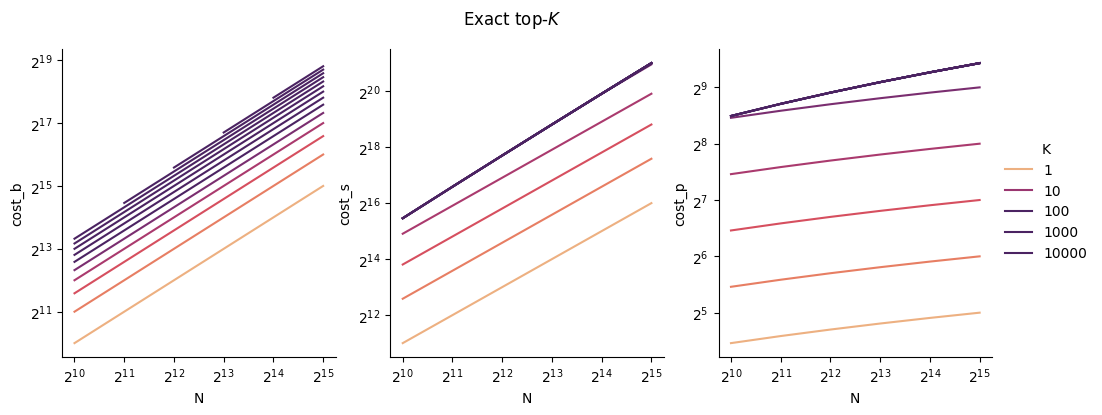

In [92]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for y, ax in zip(["cost_b", "cost_s", "cost_p"], axs):
    sns.lineplot(data=df[df.algorithm=="exact"], y=y, x="N", hue="K", hue_norm=matplotlib.colors.LogNorm(vmax=32), palette="flare", ax=ax)
for ax in axs:
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.legend_.remove()
fig.legend(*axs[0].get_legend_handles_labels(), title="K", loc="center left", bbox_to_anchor=(.9, 0.5));
fig.suptitle("Exact top-$K$");